In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Read CSV Data
df = pd.read_csv("../data/cumulative.csv")
# Remove unnecessary features
df = df.drop(columns=["rowid", "kepid", "kepoi_name", "kepler_name", "koi_pdisposition", "koi_score", "koi_tce_delivname"])
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
# Preview "df"
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,FALSE POSITIVE,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,CONFIRMED,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## <font color="navy">Optimize Correlation Threshold to Remove Functionally Redundant Features</font>
<i><font color="sky blue"><strong>Optimization was applied in random forest (rf) model as rf does not require the distribution pattern of data<strong></font></i>

In [3]:
# Column to be used as label
target = df["koi_disposition"]    

# Transform categorical labels to numerical
from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder().fit(target.values)
encd_target = target_encoder.transform(target.values)
    
# One-hot encoding labels
from tensorflow.keras.utils import to_categorical
encd_target_categ = to_categorical(encd_target)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# List to hold correlation threshold (corr_thold) to be tested in Random Forest model
corr_thold_list = range(20, 100, 5)

# Library to hold score info. for each corr_thold
corr_thold_results = {
    "corr_thold": [],
    "number of features": [],
    "testing score": []
}

# Iterate for each corr_thold
for corr_thold in corr_thold_list:
    
    # Columns to be used as features
    features = df.drop("koi_disposition", axis=1)
    # List for names of all columns from "features"
    cols = features.columns
    # List for names of functionally redudant columns to be deleted
    col_del = []
    
    for i in range(len(cols)):
        # If B and C are both closely correlated with A, appending cols[j] rather than cols[i] will delete both B and C 
        # with no exception even if they are not correlated to each other at all, which might compromise our model
        # It has been tested that deleting "cols[i]" will yield a better score given the same correlation threshold
        [col_del.append(cols[i]) for j in range(i) if abs(features[cols[i]].corr(features[cols[j]])) > corr_thold / 100]

    # Delete functionally redundant columns
    features = features.drop(columns=col_del)
    
    # Split date into train and test    
    X_train, X_test, y_train, y_test = train_test_split(features, encd_target_categ, random_state=8)
    
    # Use MinMaxScaler for normalization as we are dealing with distance metrics        
    X_scaler_mms = MinMaxScaler().fit(X_train)
    X_train_scaled_mms = X_scaler_mms.transform(X_train)
    X_test_scaled_mms = X_scaler_mms.transform(X_test)
       
    # Create random forest classifier
    rf = RandomForestClassifier(n_estimators=200)
    rf = rf.fit(X_train_scaled_mms, y_train)

    # Append results to "corr_thold_results"
    corr_thold_results["corr_thold"].append(corr_thold / 100)
    corr_thold_results["number of features"].append(features.shape[1])
    corr_thold_results["testing score"].append(rf.score(X_test_scaled_mms, y_test))

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, fl

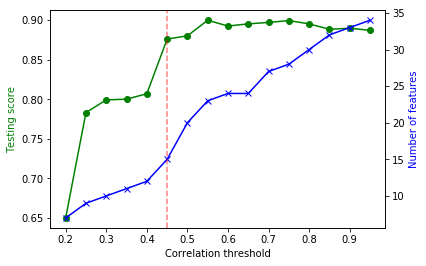

In [5]:
# Make plot for "testing score" and "number of features"
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(corr_thold_results["corr_thold"], corr_thold_results["testing score"], marker='o', color="g")
ax2.plot(corr_thold_results["corr_thold"], corr_thold_results["number of features"], marker="x", color="b")

plt.axvline(x=0.45, linestyle='dashed', c="r", alpha=0.5)

ax1.set_xlabel("Correlation threshold")
ax1.set_ylabel("Testing score", color="g")
ax2.set_ylabel("Number of features", color="b")

plt.show()

###### Based on the chart, <span style="background-color:red; color:white">correlation threshold at 0.45 with as few as 15 features</span> still retains the potential for optimized prediction

## <font color="navy">Prepare Features and Labels for Machine Learning Models</font>

In [6]:
# Set corr_thold at 0.45
corr_thold = 45

# Features used thereafter to build machine learning models (before deleting functionally redundant columns)
features = df.drop("koi_disposition", axis=1)

# List for column names to be deleted due to high correlation with others
col_del = []
# List for names of all columns from "features"
cols = features.columns

for i in range(len(cols)):
    # Append name of features (cols[i]) to "col_del" if high correlated column is found
    [col_del.append(cols[i]) for j in range(i) if abs(features[cols[i]].corr(features[cols[j]])) > corr_thold / 100]

# Delete functionally redundant columns
features = features.drop(columns=col_del)

# View names of remaining columns in features
features.columns

Index(['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_period',
       'koi_impact', 'koi_impact_err1', 'koi_duration', 'koi_depth',
       'koi_depth_err1', 'koi_teq', 'koi_insol', 'koi_tce_plnt_num',
       'koi_steff', 'ra', 'dec'],
      dtype='object')

In [7]:
# Iterate for each column in features
for col in features.columns:
    
    # Check for skewness and kurtosis
    skewness = stats.describe(features[col])[4]
    kurtosis = stats.describe(features[col])[5]
    
    # Print out column info if either skewness or kurtosis is larger than 3
    if (skewness > 3) or (kurtosis > 3):    
        print("*" * 10)
        print(f"feature name: {col}")
        print(f"skewness: {skewness}")
        print(f"kurtosis: {kurtosis}")

**********
feature name: koi_period
skewness: 2.9096056442850604
kurtosis: 8.575707227778738
**********
feature name: koi_impact
skewness: 24.545626819012853
kurtosis: 654.292256814103
**********
feature name: koi_impact_err1
skewness: 6.312551243046779
kurtosis: 40.330434371786815
**********
feature name: koi_duration
skewness: 6.142732763305333
kurtosis: 69.88306228640944
**********
feature name: koi_depth
skewness: 5.339789447449275
kurtosis: 39.95195255565689
**********
feature name: koi_depth_err1
skewness: 90.88380242228578
kurtosis: 8398.884284599475
**********
feature name: koi_teq
skewness: 3.4534017756543443
kurtosis: 27.91764996090529
**********
feature name: koi_insol
skewness: 52.04085840580866
kurtosis: 3129.058646282767
**********
feature name: koi_tce_plnt_num
skewness: 3.650882561012579
kurtosis: 16.94099602738316
**********
feature name: koi_steff
skewness: 0.7542120521681619
kurtosis: 8.074889842710324


###### Based on skewness and kurtosis study, there are two thirds columns in features whose data are not normally distributed (>3). In considering data distribution, we will use random forest, SVM, KNN, and Neural Network models thereafter

In [8]:
# Set up train and test data for all machine learning models to be built in this project
# Split date into train and test
X_train, X_test, y_train, y_test = train_test_split(features, encd_target, random_state=8)

In [9]:
# Regression models will not be used due to data distribution
# MinMaxScaler is preferred over StandardScaler for scaling features
# In this project, StandardScaler scored exactly the same as MinMaxScaler at corr_thold=0.45
X_scaler_mms = MinMaxScaler().fit(X_train)

X_train_scaled_mms = X_scaler_mms.transform(X_train)
X_test_scaled_mms = X_scaler_mms.transform(X_test)

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## <font color="navy">Random Forest Model</font>

In [10]:
# Create random forest classifier
rf = RandomForestClassifier()

# Fit model with train data
rf = rf.fit(X_train_scaled_mms, y_train)

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
# Scores for train and test data
print(f"Training Data Score: {rf.score(X_train_scaled_mms, y_train)}")
print(f"Testing Data Score: {rf.score(X_test_scaled_mms, y_test)}")

Training Data Score: 0.9926806953339433
Testing Data Score: 0.8700823421774931


In [13]:
# Create GridSearch estimator along with "n_estimators" and "max_features" parameters for hyperparameter tuning of the model
from sklearn.model_selection import GridSearchCV
# Set up tuning parameters
param_grid_rf = {'n_estimators': [50, 200, 500, 800],
                 'criterion': ["gini", "entropy"],
                 'max_features': ["sqrt", "log2"]
                 }
              
grid_rf = GridSearchCV(rf, param_grid_rf, verbose=3)

In [14]:
# Fit rf model using grid search estimator
grid_rf.fit(X_train_scaled_mms, y_train)

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] criterion=gini, max_features=sqrt, n_estimators=50 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=50, score=0.8770004572473709, total=   0.7s
[CV] criterion=gini, max_features=sqrt, n_estimators=50 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  criterion=gini, max_features=sqrt, n_estimators=50, score=0.8756287151348879, total=   0.7s
[CV] criterion=gini, max_features=sqrt, n_estimators=50 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  criterion=gini, max_features=sqrt, n_estimators=50, score=0.8681318681318682, total=   0.7s
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=200, score=0.8806584362139918, total=   3.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=200, score=0.8774577046181985, total=   3.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=200, score=0.8653846153846154, total=   3.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=500 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=500, score=0.879286694101509, total=   7.9s
[CV] criterion=gini, max_features=sqrt, n_estimators=500 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=500, score=0.8820301783264746, total=   7.9s
[CV] criterion=gini, max_features=sqrt, n_estimators=

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  6.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 200, 500, 800], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [15]:
 # List the best parameters for this dataset
print(grid_rf.best_params_)

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 500}


In [16]:
# Scores for train and test data after hyperparameter tuning of the model
print(f"Training Data Score: {grid_rf.score(X_train_scaled_mms, y_train)}")
print(f"Testing Data Score: {grid_rf.score(X_test_scaled_mms, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8911253430924062


In [17]:
# Calculate classification report
print(classification_report(
    y_test, grid_rf.predict(X_test_scaled_mms), target_names=["0", "1", "2"]
))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       510
           1       0.83      0.82      0.83       587
           2       0.97      0.98      0.98      1089

   micro avg       0.89      0.89      0.89      2186
   macro avg       0.86      0.86      0.86      2186
weighted avg       0.89      0.89      0.89      2186



In [45]:
# DataFrame for test and predicted data
target_pred_test_rf = pd.DataFrame({
    "target_test": target_encoder.inverse_transform(y_test),
    "target_predicted": target_encoder.inverse_transform(grid_rf.predict(X_test_scaled_mms))
})

# Preview "target_pred_test_rf"
target_pred_test_rf.head(16)

,target_test,target_predicted
0,FALSE POSITIVE,FALSE POSITIVE
1,FALSE POSITIVE,FALSE POSITIVE
2,CONFIRMED,CONFIRMED
3,CANDIDATE,CANDIDATE
4,FALSE POSITIVE,FALSE POSITIVE
5,CONFIRMED,CONFIRMED
6,CANDIDATE,CANDIDATE
7,FALSE POSITIVE,FALSE POSITIVE
8,FALSE POSITIVE,FALSE POSITIVE
9,FALSE POSITIVE,CANDIDATE


In [59]:
# Save model as .h5 file
from sklearn.externals import joblib
joblib.dump(grid_rf.best_estimator_, '../models/kepler_rf_model.h5')

['../data/models/kepler_rf_model.h5']

## <font color="navy">SVM Model</font>

In [111]:
# Support vector machine linear classifier
from sklearn.svm import SVC
# Create SVM classifier
svm = SVC()
# Fit model with train data
svm.fit(X_train_scaled_mms, y_train)

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [61]:
# Scores for train and test data
print(f"Training Data Score: {svm.score(X_train_scaled_mms, y_train)}")
print(f"Testing Data Score: {svm.score(X_test_scaled_mms, y_test)}")

Training Data Score: 0.786062824031717
Testing Data Score: 0.7964318389752973


In [73]:
# Set up tuning parameters
param_grid_svm = {'C': [0.1, 1, 5, 10, 50],
                  'kernel': ["linear", "poly", "rbf", "sigmoid"],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005],
                 }
              
grid_svm = GridSearchCV(svm, param_grid_svm, verbose=3)

In [74]:
# Fit svm model using grid search estimator
grid_svm.fit(X_train_scaled_mms, y_train)

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV]  C=0.1, gamma=0.0001, kernel=linear, score=0.7832647462277091, total=   0.1s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  C=0.1, gamma=0.0001, kernel=linear, score=0.7722908093278463, total=   0.1s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  C=0.1, gamma=0.0001, kernel=linear, score=0.7756410256410257, total=   0.1s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV]  C=0.1, gamma=0.0001, kernel=poly, score=0.4983996342021033, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV]  C=0.1, gamma=0.0001, kernel=poly, score=0.4983996342021033, total=   0.5s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV]  C=0.1, gamma=0.0001, kernel=poly, score=0.49862637362637363, total=   0.5s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, score=0.4983996342021033, total=   0.8s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, score=0.4983996342021033, total=   0.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, score=0.49862637362637363, total=   0.8s
[CV] C=0.1, g

[CV]  C=1, gamma=0.0001, kernel=sigmoid, score=0.4983996342021033, total=   0.7s
[CV] C=1, gamma=0.0001, kernel=sigmoid ...............................
[CV]  C=1, gamma=0.0001, kernel=sigmoid, score=0.4983996342021033, total=   0.8s
[CV] C=1, gamma=0.0001, kernel=sigmoid ...............................
[CV]  C=1, gamma=0.0001, kernel=sigmoid, score=0.49862637362637363, total=   0.7s
[CV] C=1, gamma=0.0005, kernel=linear ................................
[CV]  C=1, gamma=0.0005, kernel=linear, score=0.790580704160951, total=   0.1s
[CV] C=1, gamma=0.0005, kernel=linear ................................
[CV]  C=1, gamma=0.0005, kernel=linear, score=0.7988111568358482, total=   0.1s
[CV] C=1, gamma=0.0005, kernel=linear ................................
[CV]  C=1, gamma=0.0005, kernel=linear, score=0.7756410256410257, total=   0.1s
[CV] C=1, gamma=0.0005, kernel=poly ..................................
[CV]  C=1, gamma=0.0005, kernel=poly, score=0.4983996342021033, total=   0.5s
[CV] C=1, gam

[CV]  C=5, gamma=0.0005, kernel=poly, score=0.4983996342021033, total=   0.5s
[CV] C=5, gamma=0.0005, kernel=poly ..................................
[CV]  C=5, gamma=0.0005, kernel=poly, score=0.49862637362637363, total=   0.5s
[CV] C=5, gamma=0.0005, kernel=rbf ...................................
[CV]  C=5, gamma=0.0005, kernel=rbf, score=0.7375400091449474, total=   0.8s
[CV] C=5, gamma=0.0005, kernel=rbf ...................................
[CV]  C=5, gamma=0.0005, kernel=rbf, score=0.7338820301783264, total=   0.8s
[CV] C=5, gamma=0.0005, kernel=rbf ...................................
[CV]  C=5, gamma=0.0005, kernel=rbf, score=0.7348901098901099, total=   0.9s
[CV] C=5, gamma=0.0005, kernel=sigmoid ...............................
[CV]  C=5, gamma=0.0005, kernel=sigmoid, score=0.4983996342021033, total=   0.7s
[CV] C=5, gamma=0.0005, kernel=sigmoid ...............................
[CV]  C=5, gamma=0.0005, kernel=sigmoid, score=0.49885688157293095, total=   0.7s
[CV] C=5, gamma=0.0005,

[CV]  C=10, gamma=0.0005, kernel=sigmoid, score=0.7348901098901099, total=   0.7s
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV]  C=10, gamma=0.001, kernel=linear, score=0.788294467306813, total=   0.1s
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV]  C=10, gamma=0.001, kernel=linear, score=0.7942386831275721, total=   0.1s
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV]  C=10, gamma=0.001, kernel=linear, score=0.7673992673992674, total=   0.1s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV]  C=10, gamma=0.001, kernel=poly, score=0.4983996342021033, total=   0.5s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV]  C=10, gamma=0.001, kernel=poly, score=0.4983996342021033, total=   0.5s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV]  C=10, gamma=0.001, kernel=poly, score=0.49862637362637363, total=   0.5s
[CV] C=10, gamma=0

[CV]  C=50, gamma=0.001, kernel=rbf, score=0.7832647462277091, total=   0.4s
[CV] C=50, gamma=0.001, kernel=rbf ...................................
[CV]  C=50, gamma=0.001, kernel=rbf, score=0.772748056698674, total=   0.4s
[CV] C=50, gamma=0.001, kernel=rbf ...................................
[CV]  C=50, gamma=0.001, kernel=rbf, score=0.7751831501831502, total=   0.3s
[CV] C=50, gamma=0.001, kernel=sigmoid ...............................
[CV]  C=50, gamma=0.001, kernel=sigmoid, score=0.7690900777320531, total=   0.3s
[CV] C=50, gamma=0.001, kernel=sigmoid ...............................
[CV]  C=50, gamma=0.001, kernel=sigmoid, score=0.7521719250114312, total=   0.3s
[CV] C=50, gamma=0.001, kernel=sigmoid ...............................
[CV]  C=50, gamma=0.001, kernel=sigmoid, score=0.7614468864468864, total=   0.3s
[CV] C=50, gamma=0.005, kernel=linear ................................
[CV]  C=50, gamma=0.005, kernel=linear, score=0.7901234567901234, total=   0.2s
[CV] C=50, gamma=0.00

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  3.4min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 5, 10, 50], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [0.0001, 0.0005, 0.001, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [75]:
# List the best parameters for this dataset
print(grid_svm.best_params_)

{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}


In [76]:
# Scores for train and test data after hyperparameter tuning of the model
print(f"Training Data Score: {grid_svm.score(X_train_scaled_mms, y_train)}")
print(f"Testing Data Score: {grid_svm.score(X_test_scaled_mms, y_test)}")

Training Data Score: 0.786062824031717
Testing Data Score: 0.7964318389752973


In [77]:
# Calculate classification report
print(classification_report(
    y_test, grid_svm.predict(X_test_scaled_mms), target_names=["0", "1", "2"]
))

              precision    recall  f1-score   support

           0       0.71      0.33      0.45       510
           1       0.59      0.88      0.71       587
           2       0.98      0.97      0.97      1089

   micro avg       0.80      0.80      0.80      2186
   macro avg       0.76      0.73      0.71      2186
weighted avg       0.81      0.80      0.78      2186



In [78]:
# DataFrame for test and predicted data
target_pred_test_svm = pd.DataFrame({
    "target_test": target_encoder.inverse_transform(y_test),
    "target_predicted": target_encoder.inverse_transform(grid_svm.predict(X_test_scaled_mms))
})

# Preview "target_pred_test_svm"
target_pred_test_svm.head(16)

,target_test,target_predicted
0,FALSE POSITIVE,FALSE POSITIVE
1,FALSE POSITIVE,FALSE POSITIVE
2,CONFIRMED,CONFIRMED
3,CANDIDATE,CONFIRMED
4,FALSE POSITIVE,FALSE POSITIVE
5,CONFIRMED,CONFIRMED
6,CANDIDATE,CONFIRMED
7,FALSE POSITIVE,FALSE POSITIVE
8,FALSE POSITIVE,FALSE POSITIVE
9,FALSE POSITIVE,CANDIDATE


In [110]:
# Save model as .h5 file
joblib.dump(grid_svm.best_estimator_, '../models/kepler_svm_model.h5')

['../models/kepler_svm_model.h5']

## <font color="navy">KNN Model</font>

In [112]:
from sklearn.neighbors import KNeighborsClassifier

k: 1, Train/Test Score: 1.000/0.750
k: 3, Train/Test Score: 0.871/0.769
k: 5, Train/Test Score: 0.850/0.787
k: 7, Train/Test Score: 0.834/0.776
k: 9, Train/Test Score: 0.826/0.775
k: 11, Train/Test Score: 0.812/0.779
k: 13, Train/Test Score: 0.811/0.783
k: 15, Train/Test Score: 0.812/0.778
k: 17, Train/Test Score: 0.807/0.775
k: 19, Train/Test Score: 0.801/0.777
k: 21, Train/Test Score: 0.800/0.780
k: 23, Train/Test Score: 0.798/0.779
k: 25, Train/Test Score: 0.799/0.784
k: 27, Train/Test Score: 0.798/0.785
k: 29, Train/Test Score: 0.797/0.783


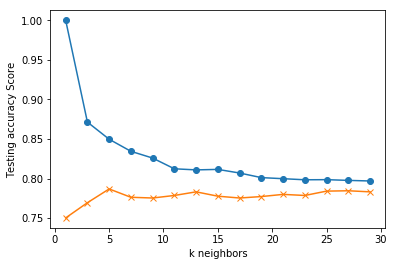

In [116]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 30, 2):
    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit model with train data
    knn.fit(X_train_scaled_mms, y_train)
    # Scores for train and test data for each k
    train_score = knn.score(X_train_scaled_mms, y_train)
    test_score = knn.score(X_test_scaled_mms, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")

 
    
    
plt.plot(range(1, 30, 2), train_scores, marker='o')
plt.plot(range(1, 30, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [117]:
# Note that k: 25 seems to be the best choice for this dataset
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_scaled_mms, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

In [118]:
# Scores for train and test data
print(f"Training Data Score: {knn.score(X_train_scaled_mms, y_train)}")
print(f"Testing Data Score: {knn.score(X_test_scaled_mms, y_test)}")

Training Data Score: 0.7985666361695639
Testing Data Score: 0.7840805123513266


In [119]:
# Set up tuning parameters
param_grid_knn = {'weights': ["uniform", "distance"],
                  'algorithm': ["ball_tree", "kd_tree", "brute"],
                  'p': [1, 2]
                 }
              
grid_knn = GridSearchCV(knn, param_grid_knn, verbose=3)

In [120]:
# Fit knn model using grid search estimator
grid_knn.fit(X_train_scaled_mms, y_train)

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] algorithm=ball_tree, p=1, weights=uniform .......................
[CV]  algorithm=ball_tree, p=1, weights=uniform, score=0.7850937357110197, total=   0.1s
[CV] algorithm=ball_tree, p=1, weights=uniform .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  algorithm=ball_tree, p=1, weights=uniform, score=0.7745770461819844, total=   0.1s
[CV] algorithm=ball_tree, p=1, weights=uniform .......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  algorithm=ball_tree, p=1, weights=uniform, score=0.7568681318681318, total=   0.1s
[CV] algorithm=ball_tree, p=1, weights=distance ......................
[CV]  algorithm=ball_tree, p=1, weights=distance, score=0.7832647462277091, total=   0.1s
[CV] algorithm=ball_tree, p=1, weights=distance ......................
[CV]  algorithm=ball_tree, p=1, weights=distance, score=0.7704618198445359, total=   0.1s
[CV] algorithm=ball_tree, p=1, weights=distance ......................
[CV]  algorithm=ball_tree, p=1, weights=distance, score=0.7554945054945055, total=   0.1s
[CV] algorithm=ball_tree, p=2, weights=uniform .......................
[CV]  algorithm=ball_tree, p=2, weights=uniform, score=0.7649748513946045, total=   0.1s
[CV] algorithm=ball_tree, p=2, weights=uniform .......................
[CV]  algorithm=ball_tree, p=2, weights=uniform, score=0.7754915409236397, total=   0.1s
[CV] algorithm=ball_tree, p=2, weights=uniform .......................
[CV]  algorithm=ball_tree, p=2, weigh

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   19.1s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [121]:
# List the best parameters for this dataset
print(grid_knn.best_params_)

{'algorithm': 'ball_tree', 'p': 1, 'weights': 'uniform'}


In [122]:
# Scores for train and test data after hyperparameter tuning of the model
print(f"Training Data Score: {grid_knn.score(X_train_scaled_mms, y_train)}")
print(f"Testing Data Score: {grid_knn.score(X_test_scaled_mms, y_test)}")

Training Data Score: 0.8007014333638305
Testing Data Score: 0.7891125343092407


In [123]:
# Calculate classification report
print(classification_report(
    y_test, grid_knn.predict(X_test_scaled_mms), target_names=["0", "1", "2"]
))

              precision    recall  f1-score   support

           0       0.61      0.43      0.51       510
           1       0.60      0.76      0.67       587
           2       0.98      0.97      0.97      1089

   micro avg       0.79      0.79      0.79      2186
   macro avg       0.73      0.72      0.72      2186
weighted avg       0.79      0.79      0.78      2186



In [124]:
# DataFrame for test and predicted data
target_pred_test_knn = pd.DataFrame({
    "target_test": target_encoder.inverse_transform(y_test),
    "target_predicted": target_encoder.inverse_transform(grid_knn.predict(X_test_scaled_mms))
})

# Preview "target_pred_test_knn"
target_pred_test_knn.head(16)

,target_test,target_predicted
0,FALSE POSITIVE,FALSE POSITIVE
1,FALSE POSITIVE,FALSE POSITIVE
2,CONFIRMED,CONFIRMED
3,CANDIDATE,CONFIRMED
4,FALSE POSITIVE,FALSE POSITIVE
5,CONFIRMED,CONFIRMED
6,CANDIDATE,CONFIRMED
7,FALSE POSITIVE,FALSE POSITIVE
8,FALSE POSITIVE,FALSE POSITIVE
9,FALSE POSITIVE,CANDIDATE


In [125]:
# Save model as .h5 file
joblib.dump(grid_knn.best_estimator_, '../models/kepler_knn_model.h5')

['../models/kepler_knn_model.h5']